In [158]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_auc_score,classification_report



In [159]:
df_original=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df=df_original.copy()

# Replace whitespace or empty strings with NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Drop rows where `TotalCharges` is NaN
df = df.dropna(subset=["TotalCharges"])

df["Churn"]=df["Churn"].map({'No':0, "Yes":1})
# Target
y=df['Churn'].copy()

# Deciding Factors
deciding_factors = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
                    'PaymentMethod', 'tenure', 'MonthlyCharges', 'TotalCharges']

X=df[deciding_factors].copy()




#print(X["TotalCharges"]).dtype
# Encoding
cat_factors = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']
num_factors = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Dropna
X=X.dropna()
# One-hot encode multi-category vars (e.g., Contract, PaymentMethod)
X_encoded = pd.get_dummies(X, columns=cat_factors, drop_first=True) # Encoded features

print(X_encoded.columns)

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner_Yes',
       'Dependents_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [160]:
# X_test_final_set, y_test_final_set --> they will be used for final testing and model evaluation
X_train,X_test_final_set, y_train, y_test_final_set=train_test_split(X_encoded,y, test_size=0.2, random_state=42, stratify=y,shuffle=True)


# Dividing X_train,y_train into actual training set and development test set
X_train_actual,X_test_dev_set, y_train_actual, y_test_dev_set=train_test_split(X_train,y_train, test_size=0.2, random_state=42, stratify=y_train,shuffle=True)


X_train_actual.isnull().sum()
X_train_actual

from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_actual)
X_test_dev_set_scaled=scaler.transform(X_test_dev_set) # Use this at development stage
X_test_final_set_scaled=scaler.transform(X_test_final_set)  # Use this for final evaluation

In [161]:
from sklearn.linear_model import LogisticRegression

# Modeling
final_model = LogisticRegression(
    C=0.010022268827315503,      # Inverse regularization strength (small value means stronger regularization)
    penalty='l1',                 # L1 penalty for sparsity (good for feature selection)
    solver='liblinear',           # Suitable for L1 and smaller datasets
    class_weight='balanced'       # Handles class imbalance, which aligns with your recall focus
)                                                                                                                 # This is the best model so far.

# Fit the model (ensure X_train_scaled and y_train_actual are defined and preprocessed)
final_model.fit(X_train_scaled, y_train_actual)
scores = cross_val_score(final_model, X_train_scaled,y_train_actual, cv=5)

In [162]:
# Prediction
y_pred = final_model.predict(X_test_final_set_scaled)
y_pred_proba=final_model.predict_proba(X_test_final_set_scaled)[:,1]


# Also for dev set
y_pred_dev=final_model.predict(X_test_dev_set_scaled)
y_pred_proba_dev=final_model.predict_proba(X_test_dev_set_scaled)[:,1]
print(classification_report(y_test_dev_set,y_pred_dev))
print(roc_auc_score(y_test_dev_set,y_pred_proba_dev))

#Eva;uation
from sklearn.metrics import  roc_auc_score,classification_report
print(classification_report(y_test_final_set,y_pred))
print(roc_auc_score(y_test_final_set,y_pred_proba))

              precision    recall  f1-score   support

           0       0.91      0.69      0.79       826
           1       0.49      0.82      0.61       299

    accuracy                           0.73      1125
   macro avg       0.70      0.76      0.70      1125
weighted avg       0.80      0.73      0.74      1125

0.8350899284944974
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1033
           1       0.48      0.82      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.75      0.69      1407
weighted avg       0.79      0.71      0.73      1407

0.83158315689208


***Interpretation***

In [163]:
final_model.coef_[0]
Feature_importances=pd.DataFrame({'Feature':X_train_actual.columns,'Coefficient':final_model.coef_[0]})
abs_coefficient=Feature_importances['Coefficient'].abs()
Feature_importances['abs_coefficient']=abs_coefficient
top_10_by_coefficient=Feature_importances.sort_values(by='abs_coefficient',ascending=False).head(10)
top_10_list_by_coefficient=top_10_by_coefficient['Feature'].to_list()
top_10_list_by_coefficient

['tenure',
 'MonthlyCharges',
 'Contract_Two year',
 'Contract_One year',
 'PaymentMethod_Electronic check',
 'OnlineSecurity_Yes',
 'DeviceProtection_No internet service',
 'TechSupport_Yes',
 'PaperlessBilling_Yes',
 'Dependents_Yes']

In [164]:
# Permutation Importance
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(final_model, X_test_final_set_scaled,y_test_final_set, n_repeats=10, random_state=50, n_jobs=2, scoring='recall')
result['importances_mean']

permutation_importance_df=pd.DataFrame({'Feature':X_test_final_set.columns,'Importance':result['importances_mean']})
print(permutation_importance_df)

                                  Feature  Importance
0                                  tenure    0.120856
1                          MonthlyCharges    0.021390
2                            TotalCharges    0.000000
3                             Partner_Yes    0.000000
4                          Dependents_Yes   -0.004011
5      OnlineSecurity_No internet service   -0.007487
6                      OnlineSecurity_Yes    0.006952
7        OnlineBackup_No internet service    0.000000
8                        OnlineBackup_Yes    0.000000
9    DeviceProtection_No internet service   -0.021390
10                   DeviceProtection_Yes    0.000000
11        TechSupport_No internet service    0.000000
12                        TechSupport_Yes    0.002941
13                      Contract_One year   -0.014171
14                      Contract_Two year    0.076738
15                   PaperlessBilling_Yes    0.002406
16  PaymentMethod_Credit card (automatic)    0.000000
17         PaymentMethod_Ele

In [165]:

absolute_value_importance=permutation_importance_df['Importance'].abs()
permutation_importance_df['absolute_value_importance']=absolute_value_importance
top_10_by_permutation_importance=permutation_importance_df.sort_values(by='absolute_value_importance',ascending=False).head(10)
top_10_list_by_permutation_importance=top_10_by_permutation_importance['Feature'].to_list()
top_10_list_by_permutation_importance

['tenure',
 'Contract_Two year',
 'MonthlyCharges',
 'DeviceProtection_No internet service',
 'Contract_One year',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'PaymentMethod_Electronic check',
 'Dependents_Yes',
 'TechSupport_Yes']

In [166]:
import shap
import numpy as np

explainer = shap.LinearExplainer(final_model, X_train_scaled)
shap_values=explainer.shap_values(X_test_final_set_scaled)
absolute_shap_values=np.abs(shap_values)
mean_shap_value=np.mean(absolute_shap_values,axis=0)
shap_importance_df=pd.DataFrame({'Feature':X_test_final_set.columns,'Importance':mean_shap_value})
#print(shap_importance_df.sort_values(by='Importance', ascending=False))
top_10_by_shape_value=shap_importance_df.sort_values(by='Importance', ascending=False).head(10)
print(top_10_by_shape_value.to_string(index=False))

top_10_list_by_shape_value=top_10_by_shape_value['Feature'].to_list()
top_10_list_by_shape_value

                             Feature  Importance
                              tenure    0.506771
                      MonthlyCharges    0.378771
                   Contract_Two year    0.368287
                   Contract_One year    0.209016
      PaymentMethod_Electronic check    0.157775
                  OnlineSecurity_Yes    0.134561
                     TechSupport_Yes    0.116656
DeviceProtection_No internet service    0.111978
                PaperlessBilling_Yes    0.075429
                      Dependents_Yes    0.048438


['tenure',
 'MonthlyCharges',
 'Contract_Two year',
 'Contract_One year',
 'PaymentMethod_Electronic check',
 'OnlineSecurity_Yes',
 'TechSupport_Yes',
 'DeviceProtection_No internet service',
 'PaperlessBilling_Yes',
 'Dependents_Yes']

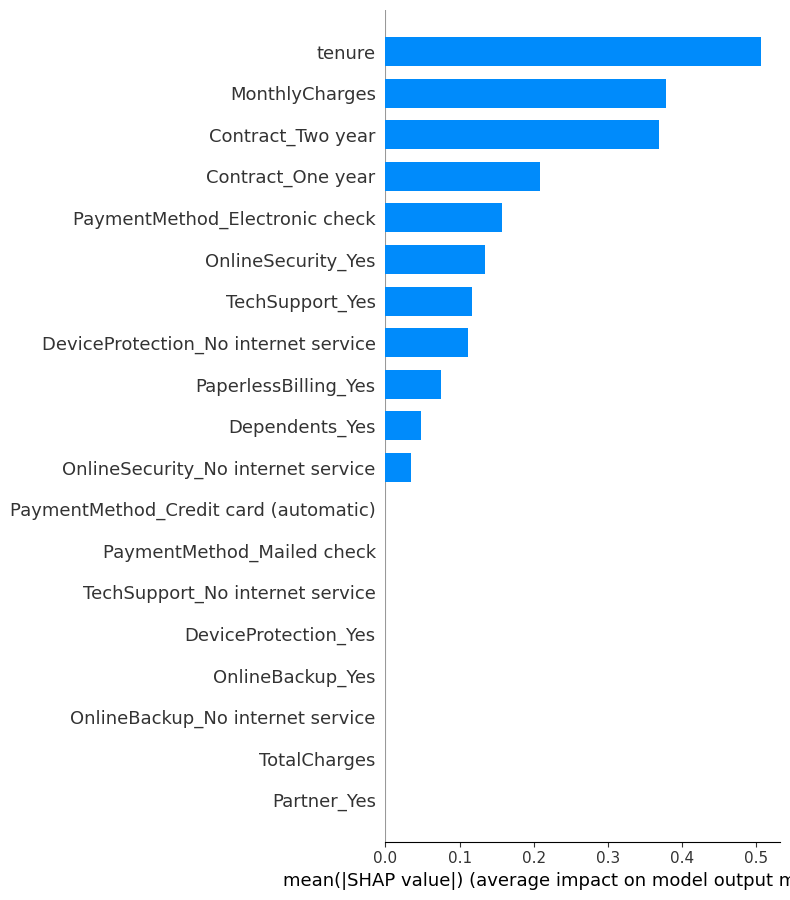

In [167]:
shap.summary_plot(shap_values, X_test_final_set, plot_type="bar")

In [168]:
from typing import Final
top_10_list_by_coefficient
top_10_list_by_permutation_importance
top_10_list_by_shape_value

Final_list=[]
for item in top_10_list_by_coefficient:
    if item in top_10_list_by_permutation_importance and item in top_10_list_by_shape_value:
        Final_list.append(item)
print(Final_list)
print(len(Final_list))

['tenure', 'MonthlyCharges', 'Contract_Two year', 'Contract_One year', 'PaymentMethod_Electronic check', 'OnlineSecurity_Yes', 'DeviceProtection_No internet service', 'TechSupport_Yes', 'Dependents_Yes']
9


['tenure', 'MonthlyCharges', 'Contract_Two year', 'Contract_One year', 'PaymentMethod_Electronic check', 'TechSupport_No internet service', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'PaperlessBilling_Yes', 'Dependents_Yes']--> These are the final top 10 features that are driving the model. **Now we can simplify the model and save computational cost by only using these features**.


# **Error Analysis or Slice Analysis**

In [169]:
# tenure < 36 months and > 36 months
df_tenure_greaterthan_36=df[df['tenure']>36]
df_tenure_lessthan_36=df[df['tenure']<36]

df_tenure_lessthan_36.iloc[[10]]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
14,5129-JLPIS,Male,0,No,No,25,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.5,2686.05,0


[1]


4283    0
Name: Churn, dtype: int64


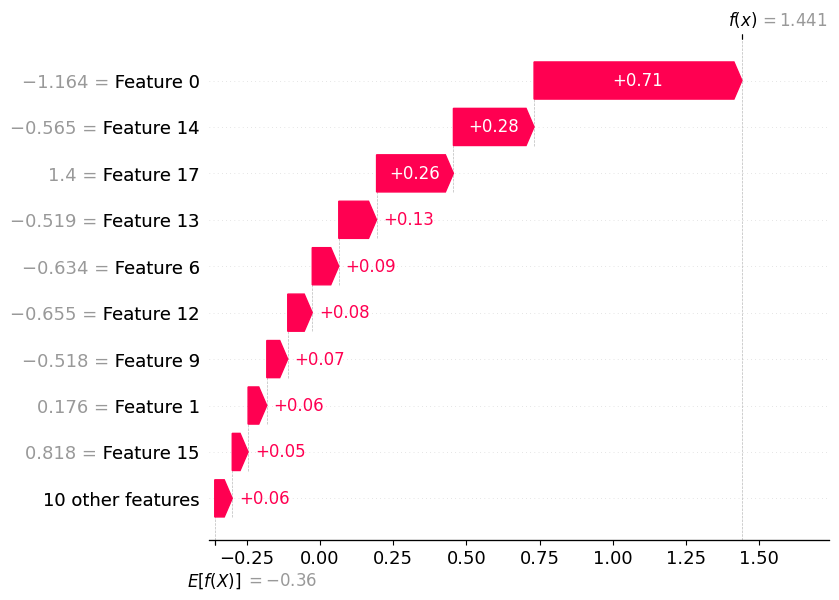

.values =
array([[ 0.71022108,  0.06384428, -0.        ,  0.        ,  0.0379332 ,
         0.0218595 ,  0.09057913, -0.        , -0.        ,  0.07157652,
        -0.        , -0.        ,  0.08373222,  0.12915476,  0.27554188,
         0.05413573, -0.        ,  0.26251685, -0.        ]])

.base_values =
array([-0.3598554])

.data =
array([[-1.16393691,  0.17558788, -0.89010785,  1.02657522, -0.66020051,
        -0.51799631, -0.63427598, -0.51799631, -0.74062157, -0.51799631,
        -0.7252179 , -0.51799631, -0.65465367, -0.51937625, -0.56468979,
         0.81838794, -0.52385734,  1.40018796, -0.54344897]])

In [170]:
# Instance Level Analysis
X_train_scaled = scaler.fit_transform(X_train_actual)
X_test_dev_set_scaled=scaler.transform(X_test_dev_set) # Use this at development stage
X_test_final_set_scaled=scaler.transform(X_test_final_set)  # Use this for final evaluation
i=10
X_test_final_set.iloc[[i]]
result_for_ith_row=final_model.predict(X_test_final_set_scaled[[i]])
print(result_for_ith_row)
print('\n')
print(y_test_final_set.iloc[[i]])
# The model predicted it will churn but the test dataset shows it wont churn. We need to find why did this happen?

# Shap analysis


import shap



# SHAP explainer initialization
explainer = shap.LinearExplainer(final_model, X_train_scaled)  # Pass scaled training data as masker

# Compute SHAP values for the i-th row (scaled data)
shap_values = explainer(X_test_final_set_scaled[[i]])  # Use explainer() instead of .shap_values()

# Visualize SHAP values using a waterfall plot
shap.plots.waterfall(shap_values[0])  # Waterfall plot for the i-th row


shap_values

In [171]:
X_test_final_set.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner_Yes',
       'Dependents_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

Important Features: ['tenure', 'MonthlyCharges', 'Contract_Two year', 'Contract_One year', 'PaymentMethod_Electronic check', 'TechSupport_No internet service', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'PaperlessBilling_Yes', 'Dependents_Yes']

Mental map: Q) How many customers churn just after one month of service?
Ans: If **a lot churns**, it suggest the ** first impression is not great** . Then the model helps us analyze the reasons of churn.


In [172]:
# Model Interpretation
df_tenure_1=df[df['tenure']==1]
n_customers=df_tenure_1.shape[0]
percent_of_df_tenure_1_customers=(n_customers/df.shape[0])*100
percent_of_df_tenure_1_customers  # The percentage is 8.7%.
print('Total_number:',n_customers)
print("How many of them churn:",df_tenure_1['Churn'].sum())
print("percentage of churn:",(df_tenure_1['Churn'].sum()/n_customers)*100) # Almost 62% churns

Total_number: 613
How many of them churn: 380
percentage of churn: 61.99021207177814


62% of churn indicates the first impression is really bad. or there are significant issues with  service during the initial stages of customer interaction.

In [128]:
# Extracting rows

Mental map: If the shap value of the total charges in 50% of churned customers are highest then, total charges is the reason behind bad first impression.

In [214]:
import pandas as pd
import shap



# Filter churned customers
filtered_data = df[(df['Churn'] == 1) & (df['tenure'] == 1)]

# Extract relevant features for SHAP analysis
X =filtered_data[deciding_factors].copy()

# Extract target
y=filtered_data['Churn'].copy()

cat_factors = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']

#Encoding
X_encoded_tenure_1 = pd.get_dummies(X, columns=cat_factors, drop_first=True) # Encoded features
X_encoded_tenure_1  =X_encoded_tenure_1.reindex(columns=X_encoded.columns, fill_value=0)

# 'Contract_One year', 'Contract_Two year'
# Scaling

X_scaled_filtered = scaler.transform(X_encoded_tenure_1)


# # Load our trained model
y_predict=final_model.predict(X_scaled_filtered)

y_predict.shape

(380,)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [216]:
import shap

# Create SHAP explainer (assuming a tree-based model or linear model)
explainer = shap.Explainer(final_model, X_scaled)
shap_values = explainer(X_scaled_filtered)


In [217]:
import numpy as np
import pandas as pd

# Absolute SHAP values show "strength of impact"
shap_df = pd.DataFrame(
    shap_values.values,
    columns=X_encoded_tenure_1.columns
)

# Find the top feature per row
top_features = shap_df.abs().idxmax(axis=1)

# Count how many times each feature is the top one
feature_counts = top_features.value_counts(normalize=True) * 100  # % of rows
print(feature_counts)
print(top_features)


tenure    100.0
Name: proportion, dtype: float64
0      tenure
1      tenure
2      tenure
3      tenure
4      tenure
        ...  
375    tenure
376    tenure
377    tenure
378    tenure
379    tenure
Length: 380, dtype: object


In [218]:
# Drop constant columns
constant_cols = [col for col in X_encoded_tenure_1.columns if X_encoded_tenure_1[col].nunique() == 1]
shap_df = shap_df.drop(columns=constant_cols)

In [219]:
# Find top feature per row
top_features = shap_df.abs().idxmax(axis=1)

# Count how many times each feature is top
feature_counts = top_features.value_counts(normalize=True) * 100
print(feature_counts)

# Apply >50% rule
if feature_counts.iloc[0] > 50:
    print(f"{feature_counts.index[0]} is the main reason for churn in this subset.")


MonthlyCharges                    56.842105
PaymentMethod_Electronic check    41.578947
OnlineSecurity_Yes                 0.789474
TechSupport_Yes                    0.789474
Name: proportion, dtype: float64
MonthlyCharges is the main reason for churn in this subset.


If the customers churns when tenure is one month, then monthly charges is the main reason. Which says that customers are either not clear about the bill or they are not satisfied with the hidden charges or the charge did not match their expectation.

In [220]:
if feature_counts.get("TotalCharges", 0) > 50:
    print("TotalCharges is the main reason for churn in this subset.")
elif feature_counts.get("MonthlyCharges", 0) > 50:
    print("MonthlyCharges is the main reason for churn in this subset.")
else:
    print("No single feature dominates >50% of churn reasons.")


MonthlyCharges is the main reason for churn in this subset.


In [221]:
# Find top feature per row
top_features = shap_df.abs().idxmax(axis=1)

# Count how many times each feature is top
feature_counts = top_features.value_counts(normalize=True) * 100
print(feature_counts)

# Apply >50% rule
if feature_counts.iloc[0] > 50:
    print(f"{feature_counts.index[0]} is the main reason for churn in this subset.")



MonthlyCharges                    56.842105
PaymentMethod_Electronic check    41.578947
OnlineSecurity_Yes                 0.789474
TechSupport_Yes                    0.789474
Name: proportion, dtype: float64
MonthlyCharges is the main reason for churn in this subset.


For customers who actually churned, what pushed the model to predict churn?

In [222]:
# Predict using the scaled, encoded features
y_pred = final_model.predict(X_scaled_filtered)
y_pred.shape

(380,)

In [229]:
# Keep only rows where model predicted churn
X_shap_analysis = X_encoded_tenure_1[y_pred == 1]
shap_values_filtered = explainer(X_shap_analysis )
shap_df_filtered = pd.DataFrame(shap_values_filtered.values, columns=X_shap_analysis.columns)
shap_df_filtered

,tenure,MonthlyCharges,TotalCharges,Partner_Yes,Dependents_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.535104,17.325659,0.0,0.0,-0.005975,0.00382,0.001044,-0.0,0.0,0.012508,0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.177746,0.0
1,-0.535104,13.195207,0.0,0.0,-0.057273,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,-0.000177,-0.0,0.177746,0.0
2,-0.535104,34.677926,0.0,0.0,-0.057273,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.177746,0.0
3,-0.535104,15.489903,0.0,0.0,-0.005975,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.177746,0.0
4,-0.535104,30.787871,0.0,0.0,-0.005975,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.002876,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,-0.535104,30.307077,0.0,0.0,-0.005975,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.177746,0.0
325,-0.535104,30.416349,0.0,0.0,-0.005975,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.177746,0.0
326,-0.535104,32.53621,0.0,0.0,-0.005975,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.177746,0.0
327,-0.535104,30.875288,0.0,0.0,-0.057273,0.00382,0.001044,-0.0,0.0,0.012508,-0.0,-0.0,-0.017324,-0.014494,0.017314,0.077862,-0.0,0.002876,0.0


In [233]:
# Find top feature per row
top_features = shap_df_filtered.abs().idxmax(axis=1)

# Count how many times each feature is top
feature_counts = top_features.value_counts(normalize=True) * 100
print(feature_counts)

# Apply >50% rule
if feature_counts.iloc[0] > 50:
    print(f"{feature_counts.index[0]} is the main reason for churn in this subset.")

top_features.unique()


MonthlyCharges    100.0
Name: proportion, dtype: float64
MonthlyCharges is the main reason for churn in this subset.


array(['MonthlyCharges'], dtype=object)

For customers who actually churned, what pushed the model to predict churn?
Ans: Monthly charges is the main reason behind such churn.

In the similar manner, we can perform interpretation for other features and and goals as well.